# Coding a simple decision tree with upper quantile and 70/30 ratio

This notebook was developed from an initial template given by **Code Canteen** and data scientist Lila Rose. They can be reach at http://futurecoders.org.uk/. The initial work was based on using medians as indicators and a train/test ratio of 80/20.<br>

In the following notebooks, we will use different ratios and different indicators, to see how the decision trees change (or not). For the complete explanations, please refer to the notebook *Decision-Tree-coded-model-Median-80-20*.

Author of the final document: Ester Giménez Mojón.

In this worksheet we are going to code a decision tree, which will use the calculated probabilities to make decisions about wheter a row of given data would be classified as `Iris virginica`, `Iris setosa` or `Iris versicolor`, or not, based on sepal and petal dimensions. With this information, species would be further predicted by probabilities of error.

This notebook will provide a decision tree for every one of the three different types of Iris considered. Each tree will be independent of each other.

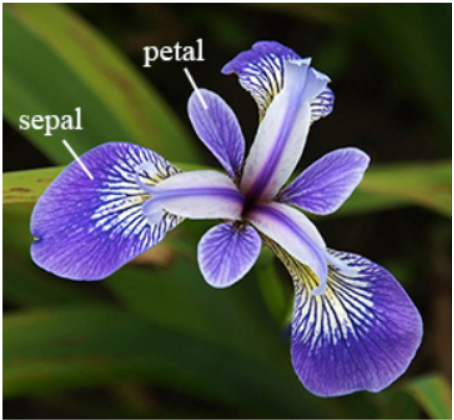

We will use:<br>

- quantile (0.75) as an indicator.<br>
- train/test percentages as 70/30.

### 1. READ THE IRIS DATASET
***

Like with the previous notebook, we will use the same iris dataset, located at https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv into a dataframe called iris_data.<br>

The columns in the CSV file do not have headings, so we need to add them:<br>

> url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"<br>
> names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']<br>
> iris_data = pd.read_csv(url, name=names)<br>

There are 150 rows of data, no empty spaces.<br>

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
iris_data = pd.read_csv(url, names=names)
iris_data.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [2]:
iris_data.quantile(0.75)

sepal-length    6.4
sepal-width     3.3
petal-length    5.1
petal-width     1.8
Name: 0.75, dtype: float64

In [3]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### 2. SPLIT THE DATA INTO TRAIN AND TEST DATASETS
***

In this case, I will use 70% train, 30% test as the split and the upper quintile as indicator.

In [4]:
# import the train_test_split function
from sklearn.model_selection import train_test_split

# create the classification variables from all columns
train, test = train_test_split(iris_data, test_size=0.30, random_state=2)
# random_state fixes the results of the calculation every time that the whole notebook is run, otherwise it will show
# different results, due to the random test_size, as it will choose different items every time.
train.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,105.000000,105.000000,105.000000,105.000000
mean,5.887619,3.057143,3.829524,1.220952
std,0.820494,0.442862,1.765749,0.760275
min,4.300000,2.000000,1.000000,0.100000
25%,5.200000,2.800000,1.500000,0.300000
50%,5.800000,3.000000,4.400000,1.400000
75%,6.400000,3.400000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The splitting will be used later, to see if the remaining data (the test set) relates very well with the train set.<br>

In order to manage decision trees, we need to decide which item we will use as a discriminator for separating values above and below it. We can use the median, the mean, quantiles (25 or 75), etc. In this case, I will use the upper quantile.<br>

### 3. ASSUMPTIONS
***

Same as in the previous notebook, we will only use the data we have on the 3 species as a representation of the species.

In [6]:
sl_indicator = iris_data['sepal-length'].quantile(0.75)
sw_indicator = iris_data['sepal-width'].quantile(0.75)
pl_indicator = iris_data['petal-length'].quantile(0.75)
pw_indicator = iris_data['petal-width'].quantile(0.75)

print(sl_indicator, sw_indicator, pl_indicator, pw_indicator)
display(train.describe())

6.4 3.3 5.1 1.8


,sepal-length,sepal-width,petal-length,petal-width
count,105.000000,105.000000,105.000000,105.000000
mean,5.887619,3.057143,3.829524,1.220952
std,0.820494,0.442862,1.765749,0.760275
min,4.300000,2.000000,1.000000,0.100000
25%,5.200000,2.800000,1.500000,0.300000
50%,5.800000,3.000000,4.400000,1.400000
75%,6.400000,3.400000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


The upper quintiles in the split differ from the values without the split only in the sepal width. All the other values are the same.<br>

- upper quintiles of the whole set: 6.4, 3.4, 5.1, 1.8<br>
- upper quintiles after split: 6.4, 3.3, 5.1, 1.8<br>

### 4. PROPORTION OF VALUES ON or ABOVE AND BELOW THE INDICATOR
***

This calculates the probability of elements in a specified column, that are:<br>

- **above** the median in relation to the total number of elements in that column. <br>
- **below** the median in relation to the total number of elements of the column.<br>

This will be used to calculate the Gini Index of the above and the below values.

__SEPAL LENGHT__

In [7]:
# Calculate the proportion of values in sepal-length column that are on or above the upper quantile
sl_vi_above_indicator = train[train['sepal-length'] >= sl_indicator]['sepal-length'].count() / train['sepal-length'].count()
sl_vi_below_indicator = train[train['sepal-length'] < sl_indicator]['sepal-length'].count() / train['sepal-length'].count()
print(sl_vi_above_indicator)
print(sl_vi_below_indicator)

0.2761904761904762
0.7238095238095238


__SEPAL WIDTH__

In [8]:
# Calculate the proportion of values in sepal-width column that are on or above the upper quantile

sw_indicator_vi_above = train[train['sepal-width'] >= sw_indicator]['sepal-width'].count() / train['sepal-width'].count()
sw_indicator_vi_below = train[train['sepal-width'] < sw_indicator]['sepal-width'].count() / train['sepal-width'].count()
print(sw_indicator_vi_above)
print(sw_indicator_vi_below)

0.29523809523809524
0.7047619047619048


__PETAL LENGHT__

In [9]:
# Calculate the proportion of values in petal-length column that are on or above the upper quantile
pl_vi_above_indicator = train[train['petal-length'] >= pl_indicator]['petal-length'].count() / train['petal-length'].count()
pl_vi_below_indicator = train[train['petal-length'] < pl_indicator]['petal-length'].count() / train['petal-length'].count()
print(pl_vi_above_indicator)
print(pl_vi_below_indicator)

0.3047619047619048
0.6952380952380952


__PETAL WIDTH__

In [10]:
# Calculate the proportion of values in petal-width column that are on or above the upper quantile
pw_vi_above_indicator = train[train['petal-width'] >= pw_indicator]['petal-width'].count() / train['petal-width'].count()
pw_vi_below_indicator = train[train['petal-width'] < pw_indicator]['petal-width'].count() / train['petal-width'].count()
print(pw_vi_above_indicator)
print(pw_vi_below_indicator)

0.3238095238095238
0.6761904761904762


The results are as follow:

|UPPER QUANTILE|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|--------------|------------|-----------|------------|-----------| 
|xx_vi_above_indicator|0.2762|0.2952|0.3047|0.3238|
|xx_vi_below_indicator|0.7238|0.7047|0.6952|0.6762|

### 5 - CALCULATION OF THE PROPORTION OF VALUES (CONDITIONED PROBABILITY) ON OR ABOVE THE INDICATOR THAT ARE OF A GIVEN SPECIES 

We will calculate the probability of a row being on or above the indicator and of a given species at the same time. <br>
The same will be done with the rows being under the indicator and of a given species at the same time.<br>
The calculations will be done for every column as well.<br>

The steps would be, for example:<br>

- Filter by values in the sepal-length column that are on or above the upper quantile (sl_indicator) and the species column being Iris-virginica.<br>
- Filter by values in the sepal-length column that are on or above the upper quantile (sl_indicator) only.<br>
- Divide both results.<br>

Instead of filtering the columns again and repeating the steps above to know which numbers are ON or ABOVE the indicator and NOT of one of the given species, we will do a substraction:<br>

> = 1 - (the proportion of those that are Iris virginica)<br>

### 5.1 - On or above the indicator and `Iris virginica` 

In [23]:
# calculate the proportion of results where the value is on or above the upper quantile that are of the species Iris-virginica
sl_vi_above = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-virginica')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-virginica')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-virginica')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-virginica')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above, sw_vi_above, pl_vi_above, pw_vi_above)

0.7241379310344828 0.1935483870967742 0.96875 0.9705882352941176


In [24]:
# calculate the proportion of results where the column is abovethe upper quantile that are NOT of the species Iris-virginica

no_sl_vi_above = 1 - sl_vi_above
no_sw_vi_above = 1 - sw_vi_above
no_pl_vi_above = 1 - pl_vi_above
no_pw_vi_above = 1 - pw_vi_above

print(no_sl_vi_above, no_sw_vi_above, no_pl_vi_above, no_pw_vi_above)

0.27586206896551724 0.8064516129032258 0.03125 0.02941176470588236


The results for `Iris Virginica` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris virg.|0.7241|0.1935|0.9687|0.9706|
|above not Iris virg.|0.2758|0.8065|0.0312|0.0294|

### 5.2 - On or above the indicator and `Iris setosa`

In [25]:
# calculate the proportion of results where the value is on or above the upper quantile that are of the species Iris-setosa
sl_vi_above_cet = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-setosa')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above_cet = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-setosa')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above_cet = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-setosa')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above_cet = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-setosa')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above_cet, sw_vi_above_cet, pl_vi_above_cet, pw_vi_above_cet)

0.0 0.7741935483870968 0.0 0.0


In [26]:
# calculate the proportion of results where the column is above the upper quantile that are NOT of the species Iris-setosa

no_sl_vi_above_cet = 1 - sl_vi_above_cet
no_sw_vi_above_cet = 1 - sw_vi_above_cet
no_pl_vi_above_cet = 1 - pl_vi_above_cet
no_pw_vi_above_cet = 1 - pw_vi_above_cet

print(no_sl_vi_above_cet, no_sw_vi_above_cet, no_pl_vi_above_cet, no_pw_vi_above_cet)

1.0 0.22580645161290325 1.0 1.0


The results for `Iris setosa` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris set.|0.0|0.7742|0.0|0.0|
|above not Iris set.|1.0|0.2258|1.0|1.0|

### 5.3 - On or above the indicator and `Iris versicolor`

In [27]:
# calculate the proportion of results where the value is on or above the upper quantile that are of the species Iris-versicolor
sl_vi_above_ver = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above_ver = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above_ver = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-versicolor')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above_ver = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-versicolor')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above_ver, sw_vi_above_ver, pl_vi_above_ver, pw_vi_above_ver)

0.27586206896551724 0.03225806451612903 0.03125 0.029411764705882353


In [28]:
# calculate the proportion of results where the column is above the upper quantile that are NOT of the species Iris-versicolor

no_sl_vi_above_ver = 1 - sl_vi_above_ver
no_sw_vi_above_ver = 1 - sw_vi_above_ver
no_pl_vi_above_ver = 1 - pl_vi_above_ver
no_pw_vi_above_ver= 1 - pw_vi_above_ver

print(no_sl_vi_above_ver, no_sw_vi_above_ver, no_pl_vi_above_ver, no_pw_vi_above_ver)

0.7241379310344828 0.967741935483871 0.96875 0.9705882352941176


The results for `Iris versicolor` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris ver.|0.2758|0.0322|0.03125|0.0294|
|above not Iris ver.|0.7241|0.9677|0.9687|0.9706|

### 6 - CALCULATION OF THE PROPORTION OF VALUES (CONDITIONED PROBABILITY) BELOW THE INDICATOR THAT ARE OF A GIVEN SPECIES

Same as section 5 but below the indicator.

### 6.1 - Below mean and `Iris virginica`

In [43]:
# calculate the proportion of results where the value is below the upper quantile that are of the species Iris-virginica

sl_vi_below = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-virginica')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below = (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-virginica')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-virginica')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-virginica')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below, sw_vi_below, pl_vi_below, pw_vi_below)

0.21052631578947367 0.4189189189189189 0.0821917808219178 0.056338028169014086


In [44]:
# calculate the proportion of results where the column is below the upper quantile that are NOT of the species Iris-virginica

no_sl_vi_below = 1-sl_vi_below
no_sw_vi_below = 1-sw_vi_below
no_pl_vi_below = 1-pl_vi_below
no_pw_vi_below = 1-pw_vi_below

print(no_sl_vi_below, no_sw_vi_below, no_pl_vi_below, no_pw_vi_below)

0.7894736842105263 0.5810810810810811 0.9178082191780822 0.9436619718309859


The results for `Iris Virginica` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris virg.|0.2105|0.4189|0.0822|0.0563|
|below not Iris virg.|0.7895|0.5811|0.9178|0.9436|

### 6.2 - Below mean and `Iris setosa`

In [31]:
# calculate the proportion of results where the value is below the upper quantile that are of the species Iris-setosa

sl_vi_below_set = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-setosa')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below_set= (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-setosa')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below_set = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-setosa')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below_set = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-setosa')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below_set, sw_vi_below_set, pl_vi_below_set, pw_vi_below_set)

0.4342105263157895 0.12162162162162163 0.4520547945205479 0.4647887323943662


In [32]:
# calculate the proportion of results where the column is below the upper quantile that are NOT of the species Iris-setosa

no_sl_vi_below_set = 1-sl_vi_below_set
no_sw_vi_below_set = 1-sw_vi_below_set
no_pl_vi_below_set = 1-pl_vi_below_set
no_pw_vi_below_set = 1-pw_vi_below_set

print(no_sl_vi_below_set, no_sw_vi_below_set, no_pl_vi_below_set, no_pw_vi_below_set)

0.5657894736842105 0.8783783783783784 0.547945205479452 0.5352112676056338


The results for `Iris setosa` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris set.|0.4342|0.1216|0.4521|0.4648|
|below not Iris set.|0.5658|0.8784|0.5479|0.5352|

### 6.3 Below mean and `Iris versicolor`

In [45]:
# calculate the proportion of results where the value is below the upper quantile that are of the species Iris-versicolor

sl_vi_below_ver = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below_ver= (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below_ver = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-versicolor')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below_ver = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-versicolor')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below_ver, sw_vi_below_ver, pl_vi_below_ver, pw_vi_below_ver)

0.35526315789473684 0.4594594594594595 0.4657534246575342 0.4788732394366197


In [46]:
# calculate the proportion of results where the column is below the upper quantile that are NOT of the species Iris-versicolor

no_sl_vi_below_ver = 1-sl_vi_below_ver
no_sw_vi_below_ver = 1-sw_vi_below_ver
no_pl_vi_below_ver = 1-pl_vi_below_ver
no_pw_vi_below_ver = 1-pw_vi_below_ver

print(no_sl_vi_below_ver, no_sw_vi_below_ver, no_pl_vi_below_ver, no_pw_vi_below_ver)

0.6447368421052632 0.5405405405405406 0.5342465753424658 0.5211267605633803


The results for `Iris versicolor` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris ver.|0.3553|0.4595|0.4657|0.4788|
|below not Iris ver.|0.6447|0.5405|0.5342|0.5211|

### 7 - Calculate Gini Index of the above and below parts, by species (not of the column).

Each time you split the data set into train and test, you will get a slightly 
different mix and so your train data set will be slightly different. We are 
going to try to look at how well we might predict a particular species from 
the 3 columns. Let's use the `Iris-virginica` species and try to predict if a 
row would be that species or not, based on the four dimensions columns.
<br>

A Gini Index is a measure of the probability of a randomly chosen prediction 
being incorrect. The most influential column will have the lowest Gini Index 
and that will be put at the top of our decision tree. <br>

The formula for the Gini Index is: <br>
<br>
Gini Index = 1 - (the sum of the squares of the proportion values calculated above) <br>
<br>
To calculate the Gini Index for, use the following example: <br>
<br>
gini_sl_vi = 1 - (sl_vi_above2 + no_sl_vi_above2)<br>

### 7.1 Gini Index of `Iris virginica` <br>

In [47]:
# calculate the Gini Index for the proportion of those above the upper quantile which are Iris_virginica, for all four columns

gini_sl_vi_above = 1 - (sl_vi_above**2 + no_sl_vi_above**2)
gini_sw_vi_above = 1 - (sw_vi_above**2 + no_sw_vi_above**2)
gini_pl_vi_above = 1 - (pl_vi_above**2 + no_pl_vi_above**2)
gini_pw_vi_above = 1 - (pw_vi_above**2 + no_pw_vi_above**2)

print(gini_sl_vi_above, gini_sw_vi_above, gini_pl_vi_above, gini_pw_vi_above)

0.3995243757431628 0.31217481789802304 0.060546875 0.05709342560553643


In [48]:
# calculate the Gini Index for the proportion of those below the upper quantile which are Iris_virginica, for all four columns

gini_sl_vi_below = 1 - (sl_vi_below**2 + no_sl_vi_below**2)
gini_sw_vi_below = 1 - (sw_vi_below**2 + no_sw_vi_below**2)
gini_pl_vi_below = 1 - (pl_vi_below**2 + no_pl_vi_below**2)
gini_pw_vi_below = 1 - (pw_vi_below**2 + no_pw_vi_below**2)

print(gini_sl_vi_below, gini_sw_vi_below, gini_pl_vi_below, gini_pw_vi_below)

0.3324099722991689 0.4868517165814463 0.15087258397447934 0.10632810950208293


The results for `Iris Virginica` are as follow:

|Gini Index I.virg|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-----------------|------------|-----------|------------|-----------| 
|above|0.3995|0.3122|0.0605|0.0571|
|below|0.3324|0.4868|0.1509|0.1063|

### 7.2 Gini Index of `Iris setosa` <br>

In [49]:
# calculate the Gini Index for the proportion of those above the upper quantile which are Iris_setosa, for all four columns

gini_sl_vi_above_cet = 1 - (sl_vi_above_cet**2 + no_sl_vi_above_cet**2)
gini_sw_vi_above_cet = 1 - (sw_vi_above_cet**2 + no_sw_vi_above_cet**2)
gini_pl_vi_above_cet = 1 - (pl_vi_above_cet**2 + no_pl_vi_above_cet**2)
gini_pw_vi_above_cet = 1 - (pw_vi_above_cet**2 + no_pw_vi_above_cet**2)

print(gini_sl_vi_above_cet, gini_sw_vi_above_cet, gini_pl_vi_above_cet, gini_pw_vi_above_cet)

0.0 0.34963579604578565 0.0 0.0


In [50]:
# calculate the Gini Index for the proportion of those below the upper quantile which are Iris_setosa, for all four columns

gini_sl_vi_below_set = 1 - (sl_vi_below_set**2 + no_sl_vi_below_set**2)
gini_sw_vi_below_set = 1 - (sw_vi_below_set**2 + no_sw_vi_below_set**2)
gini_pl_vi_below_set = 1 - (pl_vi_below_set**2 + no_pl_vi_below_set**2)
gini_pw_vi_below_set = 1 - (pw_vi_below_set**2 + no_pw_vi_below_set**2)

print(gini_sl_vi_below_set, gini_sw_vi_below_set, gini_pl_vi_below_set, gini_pw_vi_below_set)

0.49134349030470914 0.21365960555149743 0.4954025145430663 0.4975203332672089


The results for `Iris setosa` are as follow:

|Gini Index I.setosa|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-------------------|------------|-----------|------------|-----------| 
|above|0.0|0.3496|0.0|0.0|
|below|0.4913|0.2136|0.4954|0.4975|

### 7.3 Gini Index of `Iris versicolor` <br>

In [51]:
# calculate the Gini Index for the proportion of those above the upper quantile which are Iris_versicolor, for all four columns

gini_sl_vi_above_ver = 1 - (sl_vi_above_ver**2 + no_sl_vi_above_ver**2)
gini_sw_vi_above_ver = 1 - (sw_vi_above_ver**2 + no_sw_vi_above_ver**2)
gini_pl_vi_above_ver = 1 - (pl_vi_above_ver**2 + no_pl_vi_above_ver**2)
gini_pw_vi_above_ver = 1 - (pw_vi_above_ver**2 + no_pw_vi_above_ver**2)

print(gini_sl_vi_above_ver, gini_sw_vi_above_ver, gini_pl_vi_above_ver, gini_pw_vi_above_ver)

0.3995243757431628 0.06243496357960443 0.060546875 0.05709342560553643


In [52]:
# calculate the Gini Index for the proportion of those below the upper quantile which are Iris_versicolor, for all four columns

gini_sl_vi_below_ver = 1 - (sl_vi_below_ver**2 + no_sl_vi_below_ver**2)
gini_sw_vi_below_ver = 1 - (sw_vi_below_ver**2 + no_sw_vi_below_ver**2)
gini_pl_vi_below_ver = 1 - (pl_vi_below_ver**2 + no_pl_vi_below_ver**2)
gini_pw_vi_below_ver = 1 - (pw_vi_below_ver**2 + no_pw_vi_below_ver**2)

print(gini_sl_vi_below_ver, gini_sw_vi_below_ver, gini_pl_vi_below_ver, gini_pw_vi_below_ver)

0.4581024930747922 0.4967129291453616 0.4976543441546256 0.4991073199761953


The results for `Iris versicolor` are as follow:

|Gini Index I.vers|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-----------------|------------|-----------|------------|-----------| 
|above|0.3995|0.0624|0.0605|0.0571|
|below|0.4581|0.4967|0.4976|0.4991|

### 8 - Add weights to the index

### 8.1 - Gini Index of `Iris virginica`

In [53]:
# Calculate the weighted Gini Index for sepal-lenght
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above + sl_vi_below_indicator * gini_sl_vi_below
print(weighted_gini_sl_vi)

0.3509463313456053


In [54]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above + sw_indicator_vi_below * gini_sw_vi_below
print(weighted_gini_sw_vi)

0.4352804417320547


In [55]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above + pl_vi_below_indicator * gini_pl_vi_below
print(weighted_gini_pl_vi)

0.12334474885844754


In [56]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above + pw_vi_below_indicator * gini_pw_vi_below
print(weighted_gini_pw_vi)

0.09038544995462978


The results for `Iris virginica` are as follow:

|Total Gini Index I.vir|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3509|0.4352|0.1233|0.0904|

### 8.2 - Gini Index of `Iris setosa`

In [57]:
# calculate the proportion of values in sepal-length column that are on or above the upper quintile, then calculate the weighted Gini Index
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above_cet + sl_vi_below_indicator * gini_sl_vi_below_set
print(weighted_gini_sl_vi)

0.35563909774436087


In [58]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above_cet + sw_indicator_vi_below * gini_sw_vi_below_set
print(weighted_gini_sw_vi)

0.2538049570307635


In [59]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above_cet + pl_vi_below_indicator * gini_pl_vi_below_set
print(weighted_gini_pl_vi)

0.3444227005870842


In [60]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above_cet + pw_vi_below_indicator * gini_pw_vi_below_set
print(weighted_gini_pw_vi)

0.3364185110663984


The results for `Iris setosa` are as follow:

|Total Gini Index I.set|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3556|0.2538|0.3444|0.3364|

### 8.3 - Gini Index of `Iris versicolor`

In [61]:
# calculate the proportion of values in sepal-length column that are on or above the upper quintile, then calculate the weighted Gini Index
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above_ver + sl_vi_below_indicator * gini_sl_vi_below_ver
print(weighted_gini_sl_vi)

0.4419237749546279


In [62]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above_ver + sw_indicator_vi_below * gini_sw_vi_below_ver
print(weighted_gini_sw_vi)

0.3684975297878524


In [63]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above_cet + pl_vi_below_indicator * gini_pl_vi_below_set
print(weighted_gini_pl_vi)

0.3444227005870842


In [64]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above_ver + pw_vi_below_indicator * gini_pw_vi_below_ver
print(weighted_gini_pw_vi)

0.3559790113228391


The results for `Iris versicolor` are as follow:

|Total Gini Index I.ver|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.4419|0.3685|0.3444|0.3559|

### 9 - MAKE A DECISION TREE

### 9.1 `Iris virginica`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.vir|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3509|0.4352|0.1233|0.0904|

The order of the nodes is:

1. Petal width
2. Petal length
3. Sepal length
4. Sepal width

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris virg.|0.7241|0.1935|0.9687|0.9706|
|above not Iris virg.|0.2758|0.8065|0.0312|0.0294|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris virg.|0.2105|0.4189|0.0822|0.0563|
|below not Iris virg.|0.7895|0.5811|0.9178|0.9436|

First node: **petal width** there are 97% occurrences of `Iris virginica` being above the indicator, so they must be **above**.
<br>
Second node: **petal length** has 96% are above, so they be **above**.
<br>
Third node: **sepal length** has the highest occurrences with above the indicator (72%) and 78.9% being below not of the species, which makes this to be **above**.
<br>
Fourth node: **sepal width** has 80.6% above and not of the species, which means that it should be **below** (only has 41.8%). 

The decision tree is a little bit different regarding the order of the characteristics with using the median indicator:

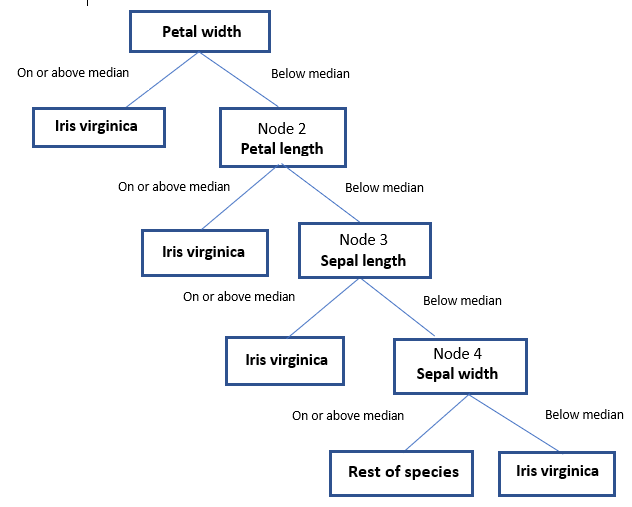

### 9.2 `Iris setosa`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.set|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3556|0.2538|0.3444|0.3364|

The order of the nodes is:

1. Sepal width
2. Petal width
3. Petal length
4. Sepal length

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris set.|0.0|0.7742|0.0|0.0|
|above not Iris set.|1.0|0.2258|1.0|1.0|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris set.|0.4342|0.1216|0.4521|0.4648|
|below not Iris set.|0.5658|0.8784|0.5479|0.5352|

First node: **sepal width** has 87% occurrences of `Iris setosa` are below and not of the species, which match with 77% being above. So it must be **above**.

Second node: **petal width** has 0% occurrences of `Iris setosa` being above the indicator, so they must be **below**.

Third node: **petal length** has 0% occurrences of `Iris setosa` being above the indicator, so they must be **below**.

Fourth node: **sepal length** has 0% probability of being above, so they must be **below**.

This decision tree follows the same splits as with the median indicator:

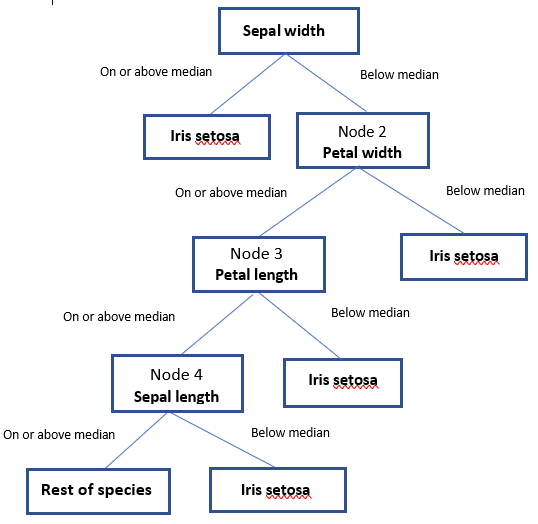

### 9.3 `Iris versicolor`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.ver|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.4419|0.3685|0.3444|0.3559|

The order of the nodes is:

1. Petal length
2. Petal width
3. Sepal width
4. Sepal length

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris ver.|0.2758|0.0322|0.03125|0.0294|
|above not Iris ver.|0.7241|0.9677|0.9687|0.9706|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris ver.|0.3553|0.4595|0.4657|0.4788|
|below not Iris ver.|0.6447|0.5405|0.5342|0.5211|

First node: **petal length**, the 86.8% of the occurrences are above and not of the species, which means the species should be **below**.
<br>
Second node: **petal width** has 97% probability are above and not of the species, so they must be **below**.
<br>
Third node: **sepal width** has 96% occurrences are above and not of the species, so they must be **below**.
<br>
Fourth node: **sepal length** has similar occurrences of above and below (27.5% above and 35.5% below). Following the same decisions as with previous indicators, we should not use sepal lenght for classifications, however I will choose **below** for this notebook.

This decision tree follows the same splits as with the median indicator, however the species is located in different splits:

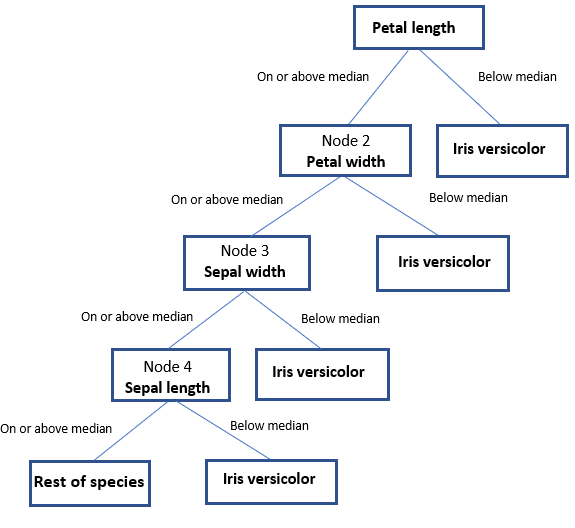

### 10 - EFFICIENCY OF THE DECISION TREES

#### 10.1 Test efficiency of the decision tree for `Iris virginica`.

In [68]:
def predict_species(df):
    if df['petal-width'] >= pw_indicator:
        if df['petal-length'] >= sl_indicator:
            #if df['sepal-length'] >= pl_indicator:
                #if df['sepal-width'] <= sw_indicator:
                #    return "Iris-virginica"
                #else:
                #    return None
            #    return "Iris-virginica"
            #else:
            #    return None
            return "Iris-virginica"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size) 

Proportion correctly identified 0.022222222222222223


The efficiency of classification of `Iris virginica` is 2.2% for 3 and 2 nodes and 0 for the 4 nodes. 
<br>
This indicator gives very low efficiencies, and not very useful for classifications. 

#### 10.2 Test efficiency of the decision tree for `Iris setosa`.

In [74]:
def predict_species(df):
    if df['sepal-width'] >= pl_indicator:
        if df['petal-width'] <= pw_indicator:
            #if df['petal-length'] <= sl_indicator:
                #if df['sepal-length'] <= sw_indicator:
                #    return "Iris-setosa"
                #else:
                #    return None
            #    return "Iris-setosa"
            #else:
            #    return None
            return "Iris-setosa"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size)

Proportion correctly identified 0.0


The efficiency of classification of `Iris setosa` is 0 for 2, 3 or 4 nodes.

#### 10.3 Test efficiency of the decision tree for `Iris versicolor`.

In [77]:
def predict_species(df):
    if df['petal-length'] <= pl_indicator:
        if df['petal-width'] <= sw_indicator:
            #if df['sepal-width'] >= sl_indicator:
                #if df['sepal-length'] >= pw_indicator:
                #    return "Iris-versicolor"
                #else:
                #    return None
            #    return "Iris-versicolor"
            #return None
            return "Iris-versicolor"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size) 

Proportion correctly identified 0.3333333333333333


The efficiency of classification of `Iris versicolor` is 0% for 3 and 4 nodes and 33.3% for 2 nodes. 

### 11 - PLOT GRAPH

For the petals we have:

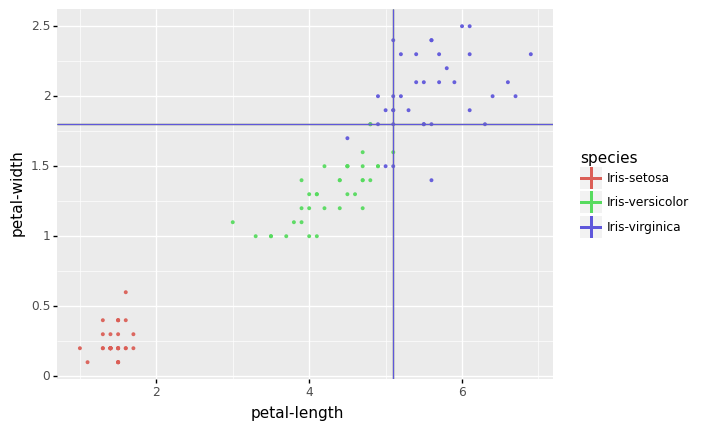

<ggplot: (145822539879)>

In [78]:
import plotly
import ggplot
from pandas import Timestamp
from plotnine import *
import warnings
warnings.filterwarnings('ignore', module='plotnine') 

(ggplot(train, aes(x='petal-length', y='petal-width', color='species')) + 
        geom_point(alpha =0.9, size = 0.6) +
        geom_vline(train, aes(xintercept=pl_indicator, color='species')) +
        geom_hline(train, aes(yintercept=pw_indicator, color='species'))
)

For the sepals we have:

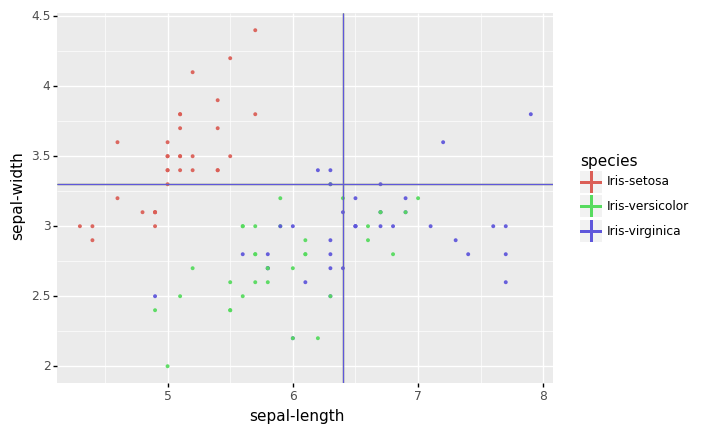

<ggplot: (145822901788)>

In [79]:
import plotly
import ggplot
from pandas import Timestamp
from plotnine import *
import warnings
warnings.filterwarnings('ignore', module='plotnine') 

(ggplot(train, aes(x='sepal-length', y='sepal-width', color='species')) + 
        geom_point(alpha =0.9, size = 0.6) +
        geom_vline(train, aes(xintercept=sl_indicator, color='species')) +
        geom_hline(train, aes(yintercept=sw_indicator, color='species'))
)

### CONCLUSION

The decision trees are very different from other indicators' trees and that could the reason why the efficiencies are so low or cero.
<br>
In general, using the upper quantile with split 70-30 should not be chosen for species's classification.